In [5]:
pip install tensorflow keras matplotlib scikit-learn

IMPORTING LIBRARIES

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

DATA PREPROCESSING

ImageDataGenerator for loading and augmenting the dataset

In [7]:
data_dir='/content/drive/MyDrive/Animal Classification/dataset'
img_size=(224,224)
batch_size=32 #number of images processed together in one pass (batch) through the model

#This is a class provided by Keras to generate batches of images with real-time data augmentation. Data augmentation helps to artificially expand the training dataset by applying transformations like rotation, zoom, and flipping to the images, which helps the model generalize better.
train_datagen=ImageDataGenerator(rescale=1./255, #This rescales the pixel values of the images from their original range of 0–255 (as stored in the dataset) to the range 0–1
                                 shear_range=0.2,#Shearing is like tilting the image along one axis
                                 zoom_range=0.2, #This randomly zooms in or out on the images by 20%
                                 horizontal_flip=True,
                                 validation_split=0.2)
#Loading training data
#This function is used to load images from the directory structure where subfolders represent different classes. It generates batches of augmented and normalized images from the directory.
train_generator=train_datagen.flow_from_directory(data_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='training')

#Loading validation data
validation_generator=train_datagen.flow_from_directory(data_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='validation'
                                                       )

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.


Basic CNN model

In [8]:
#This creates a linear stack of layers, meaning the data flows from one layer to the next sequentially
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)), #This is a 2D convolutional layer that applies 32 filters of size 3x3 to the input images. These filters slide over the image and detect various features, like edges and textures
    #The ReLU (Rectified Linear Unit) activation function introduces non-linearity, which allows the model to learn complex patterns. ReLU converts all negative values to zero, which helps the model converge faster
    MaxPooling2D(2,2), #downsampling
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3,),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(), #This layer flattens the 2D feature maps from the last convolutional layer into a 1D vector.
    Dense(512,activation='relu'), #fully connected layer with 512 neurons. classifies
    Dropout(0.5), #This layer randomly sets 50% of the neurons to zero during each training step, helping to prevent overfitting
    Dense(15,activation='softmax') #output  layer It converts the raw output values into probabilities, ensuring the sum of all probabilities equals 1
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', #for multi clas classfic ;It measures the difference between the predicted probability distribution and the true distribution.
              metrics=['accuracy'])

model.summary() #layer types, output shapes, and the number of parameters (weights and biases) in each layer.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,403,791 (169.39 MB)

 Trainable params: 44,403,791 (169.39 MB)

 Non-trainable params: 0 (0.00 B)

TRAINING CNN MODEL

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.8278 - loss: 0.5635 - val_accuracy: 0.3890 - val_loss: 2.6427
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.8534 - loss: 0.5369 - val_accuracy: 0.4230 - val_loss: 2.6874
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.8955 - loss: 0.4139 - val_accuracy: 0.4204 - val_loss: 3.2060
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.8899 - loss: 0.4220 - val_accuracy: 0.4386 - val_loss: 2.9593
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.9085 - loss: 0.2977 - val_accuracy: 0.4178 - val_loss: 3.1857
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9024 - loss: 0.3340 - val_accuracy: 0.4491 - val_loss: 3.0004
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - accuracy: 0.9133 - loss: 0.2905 - val_accuracy: 0.4621 - val_loss: 3.2533
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.9405 - loss: 0.2387 - val_accuracy: 0.4047 - v

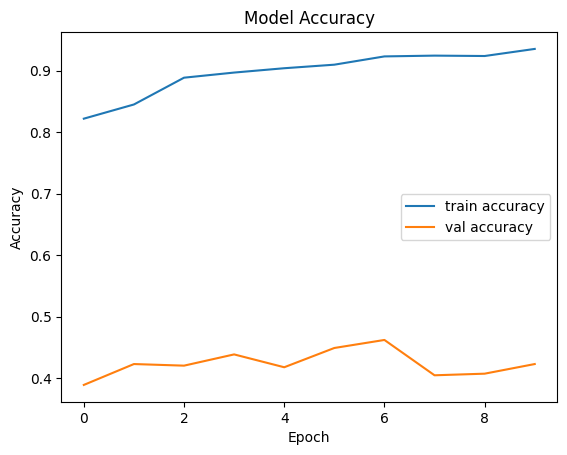

In [10]:
history=model.fit(train_generator,
                  epochs=10,
                  validation_data=validation_generator)
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Transfer learning with MobileNetV2

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.1254 - loss: 3.0179 - val_accuracy: 0.5248 - val_loss: 1.9743
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.4150 - loss: 1.9864 - val_accuracy: 0.7023 - val_loss: 1.4228
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5784 - loss: 1.5172 - val_accuracy: 0.7728 - val_loss: 1.1046
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6804 - loss: 1.1848 - val_accuracy: 0.8198 - val_loss: 0.8802
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.7360 - loss: 0.9813 - val_accuracy: 0.8303 - val_loss: 0.7722
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7716 - loss: 0.8595 - val_accuracy: 0.8355 - val_loss: 0.6706
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8008 - loss: 0.7387 - val_accuracy: 0.8303 - val_loss: 0.6372
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy:

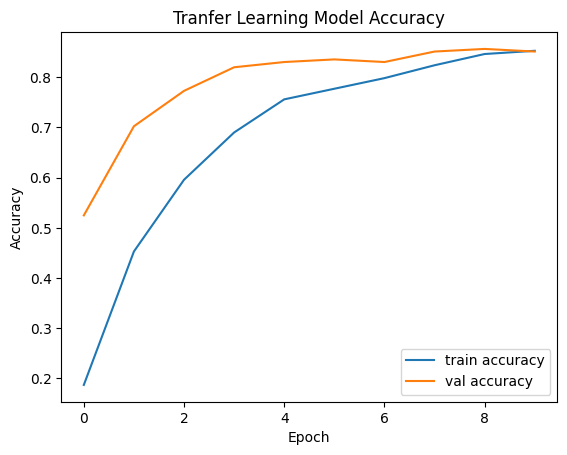

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable=False


model_transfer=Sequential([base_model,
                           GlobalAveragePooling2D(),
                           Dense(256,activation='relu'),
                           Dropout(0.5),
                           Dense(15,activation='softmax')
                           ])
optimizer = Adam(learning_rate=0.0001)
model_transfer.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
history_transfer=model_transfer.fit(train_generator,
                                    epochs=10,
                                    validation_data=validation_generator)

plt.plot(history_transfer.history['accuracy'],label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'],label='val accuracy')
plt.title('Tranfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

EVALUATING THE MODEL

In [12]:
val_loss,val_acc=model_transfer.evaluate(validation_generator)
print(f'Validation Accuracy:{val_acc:.2f}')

Y_pred=model_transfer.predict(validation_generator)
y_pred=np.argmax(Y_pred,axis=1)
print('Classification Report')
print(classification_report(validation_generator.classes,y_pred,target_names=list(validation_generator.class_indices.keys())))

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8722 - loss: 0.5154
Validation Accuracy:0.86
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Classification Report
              precision    recall  f1-score   support

        Bear       0.12      0.12      0.12        25
        Bird       0.07      0.07      0.07        27
         Cat       0.00      0.00      0.00        24
         Cow       0.16      0.19      0.18        26
        Deer       0.05      0.04      0.04        25
         Dog       0.04      0.04      0.04        24
     Dolphin       0.04      0.04      0.04        25
    Elephant       0.09      0.08      0.08        26
     Giraffe       0.15      0.16      0.15        25
       Horse       0.10      0.08      0.09        26
    Kangaroo       0.11      0.12      0.11        25
        Lion       0.15      0.15      0.15        26
       Panda       0.04      0.04      0.04        27
       Tiger       0.21      0.20      0.20        25
       Zebra       0.04      0

TESTING ON NEW IMAGES


In [35]:
from tensorflow.keras.preprocessing import image
#Dog,Elephant,Zebra,Dog,Bird
img_paths=['/content/drive/MyDrive/Animal Classification/golden-retriever-puppy.jpg','/content/drive/MyDrive/Animal Classification/NewElephantImage.jpg.webp','/content/drive/MyDrive/Animal Classification/Zeb.jpg','/content/drive/MyDrive/Animal Classification/Labrador-Retriever-standing-outdoors.jpg','/content/drive/MyDrive/Animal Classification/NewBird.jpeg']
for img_path in img_paths:
  img=image.load_img(img_path,target_size=(224,224))
  img_array=image.img_to_array(img)/255.0
  img_array=np.expand_dims(img_array,axis=0)

  prediction=model_transfer.predict(img_array)
  predicted_class=np.argmax(prediction)
  classes=list(train_generator.class_indices.keys())
  print(f'The predicted animal is: {classes[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The predicted animal is: Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
The predicted animal is: Elephant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The predicted animal is: Zebra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The predicted animal is: Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The predicted animal is: Bird
